### Top level NER

In [1]:
import os
import requests
import re
import sys
import regex as re

import spacy

# Using Spacy Large
#!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser"])

# Enable only NER
nlp.enable_pipe("ner")

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

2023-05-26 01:02:16.570323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 01:02:19.810276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 01:02:19.810410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [1]:

#!pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

from tqdm import tqdm
from collections import Counter
from itertools import chain

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
def spacy_ner(x):
    doc = nlp(x)
    entities = []
    labels = []
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
    entities_labels = list(zip(entities, labels)) #we do not want unique entities
    return entities_labels

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [3]:
import pandas as pd

In [6]:
%%time

df_processed = pd.read_parquet('06_sent_trans_df.parquet', engine='pyarrow')
df_processed.shape

CPU times: user 1min 15s, sys: 17 s, total: 1min 32s
Wall time: 1min 8s


(198564, 10)

In [7]:

# Convert the 'year_month' column to datetime format
df_processed['formatted_date'] = pd.to_datetime(df_processed['year_month'].astype(str) + '-01').dt.to_period('M').dt.to_timestamp()

# Use the 'dt' accessor to extract the month and year, and format it as "Jan 2019"
df_processed['year_month'] = df_processed['year_month'].dt.strftime('%b %Y')


In [8]:
df_processed.sample(3)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date
156465,2023-01-07,"Citizen's New Watch Uses NASA Tech, AI To Meas...","Citizen's New Watch Uses NASA Tech, AI To Meas...",Jan 2023,"[Citizen, New, Watch, Uses, NASA, Tech, AI, Me...","[citizen, new, watch, uses, nasa, tech, ai, me...",citizen new watch us nasa tech ai measure fatigue,citizen new watch uses nasa tech ai measure fa...,neutral,0.995664,2023-01-01
107237,2023-01-19,aiOla raises $25 million to interface natural ...,aiOla raises $25 million to interface natural ...,Jan 2023,"[aiOla, raise, million, interface, natural, la...","[aiola, raise, million, interface, natural, la...",aiola raise 25 million interface natural langu...,aiola raise million interface natural language...,neutral,0.999852,2023-01-01
67533,2023-01-10,"Attention raises $3.1M, unveiling their AI sal...","Attention raises $3.1M, unveiling their AI sal...",Jan 2023,"[Attention, raise, 31M, unveiling, AI, sale, a...","[attention, raise, 31m, unveiling, ai, sale, a...",attention raise 31m unveiling ai sale assistant,attention raise 31m unveiling ai sale assistan...,neutral,0.999822,2023-01-01


In [8]:
df_pos = df_processed[df_processed['sentiment_label'] == 'positive']
df_neg = df_processed[df_processed['sentiment_label'] == 'negative']

In [23]:
len(documents_neg)

4410

In [9]:
%%time
df_processed['clean_text_case_sent'] = df_processed['clean_text_case'].parallel_apply(lambda x: ' '.join(x))

CPU times: user 19.3 s, sys: 7.69 s, total: 27 s
Wall time: 25.7 s


In [10]:
%%time
tqdm.pandas()
df_processed['entities_spacy'] = df_processed['clean_text_case_sent'].parallel_apply(lambda x: spacy_ner(x)).progress_apply(lambda x: x)

100%|██████████| 198564/198564 [00:00<00:00, 928859.57it/s]

CPU times: user 2min 2s, sys: 21.8 s, total: 2min 24s
Wall time: 28min 39s


In [12]:
df_processed.head(5)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date,clean_text_case_sent,entities_spacy
0,2021-03-18,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Mar 2021,"[Artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,positive,0.997408,2021-03-01,Artificial intelligence improves parking effic...,"[(Chinese, NORP), (Chinese, NORP), (Japanese, ..."
1,2020-02-27,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Feb 2020,"[Children, Autism, Saw, Learning, Social, Skil...","[children, autism, saw, learning, social, skil...",child autism saw learning social skill boosted...,children autism saw learning social skills boo...,positive,0.999264,2020-02-01,Children Autism Saw Learning Social Skills Boo...,"[(Thursday, DATE), (Drax, ORG), (March, DATE),..."
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",Mar 2021,"[Forget, ML, AI, Industry, 40, obsolescence, f...","[forget, ml, ai, industry, 40, obsolescence, f...",forget ml ai industry 40 – obsolescence focus ...,forget ml ai industry 40 obsolescence focus fe...,neutral,0.999864,2021-03-01,Forget ML AI Industry 40 obsolescence focus Fe...,"[(Forget ML AI Industry, ORG), (40, CARDINAL),..."
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,Mar 2021,"[Strategy, Analytics, Smartphones, Sold, Globa...","[strategy, analytics, smartphones, sold, globa...",strategy analytics 71 smartphones sold globall...,strategy analytics smartphones sold globally a...,neutral,0.999874,2021-03-01,Strategy Analytics Smartphones Sold Globally A...,"[(AI Powered hour ago, TIME), (Artificial Inte..."
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...,Oct 2020,"[Olympus, Support, Endoscopic, AI, Diagnosis, ...","[olympus, support, endoscopic, ai, diagnosis, ...",olympus support endoscopic ai diagnosis educat...,olympus support endoscopic ai diagnosis educat...,neutral,0.999858,2020-10-01,Olympus Support Endoscopic AI Diagnosis Educat...,[(Olympus Support Endoscopic AI Diagnosis Educ...


In [15]:
df_processed['ENT_ORG'] = df_processed['entities_spacy'].parallel_apply(lambda x: [tup[0] for tup in x if tup[1] == "ORG"])
df_processed['ENT_PROD'] = df_processed['entities_spacy'].parallel_apply(lambda x: [tup[0] for tup in x if tup[1] == "PRODUCT"])
df_processed['ENT_PER'] = df_processed['entities_spacy'].parallel_apply(lambda x: [tup[0] for tup in x if tup[1] == "PERSON"])
df_processed['ENT_NORP'] = df_processed['entities_spacy'].parallel_apply(lambda x: [tup[0] for tup in x if tup[1] == "COMPANY"])


In [16]:
df_processed.head(5)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date,clean_text_case_sent,entities_spacy,ENT_ORG,ENT_PROD,ENT_PER,ENT_NORP
0,2021-03-18,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Mar 2021,"[Artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,positive,0.997408,2021-03-01,Artificial intelligence improves parking effic...,"[(Chinese, NORP), (Chinese, NORP), (Japanese, ...","[ETC, ETC, ETC, ETC, ETC, Wang, ETC, AIpark Sk...","[AI, AI, AI, AI, AI]","[Wang life, AIpark Sky Eye, Xiang Yanping, AIp...",[]
1,2020-02-27,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Feb 2020,"[Children, Autism, Saw, Learning, Social, Skil...","[children, autism, saw, learning, social, skil...",child autism saw learning social skill boosted...,children autism saw learning social skills boo...,positive,0.999264,2020-02-01,Children Autism Saw Learning Social Skills Boo...,"[(Thursday, DATE), (Drax, ORG), (March, DATE),...","[Drax, Italy Coronavirus Dettol, News Parliame...",[],"[Levi Strauss, Mansplaining, Levi Strauss, Sho...",[]
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",Mar 2021,"[Forget, ML, AI, Industry, 40, obsolescence, f...","[forget, ml, ai, industry, 40, obsolescence, f...",forget ml ai industry 40 – obsolescence focus ...,forget ml ai industry 40 obsolescence focus fe...,neutral,0.999864,2021-03-01,Forget ML AI Industry 40 obsolescence focus Fe...,"[(Forget ML AI Industry, ORG), (40, CARDINAL),...","[Forget ML AI Industry, Signal LSI Circuit Sys...","[Britishmade, Throughhole, lowtemp]","[Willian Santos, Durafuse LT]",[]
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,Mar 2021,"[Strategy, Analytics, Smartphones, Sold, Globa...","[strategy, analytics, smartphones, sold, globa...",strategy analytics 71 smartphones sold globall...,strategy analytics smartphones sold globally a...,neutral,0.999874,2021-03-01,Strategy Analytics Smartphones Sold Globally A...,"[(AI Powered hour ago, TIME), (Artificial Inte...","[Artificial Intelligence Powers, Smartphones B...","[AI, ondevice AI, AI, AI, AI, AI, AI, AI, Pro ...","[Ken Hyers, Ukonaho, Ken Hyers, Ukonaho Camera...",[]
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...,Oct 2020,"[Olympus, Support, Endoscopic, AI, Diagnosis, ...","[olympus, support, endoscopic, ai, diagnosis, ...",olympus support endoscopic ai diagnosis educat...,olympus support endoscopic ai diagnosis educat...,neutral,0.999858,2020-10-01,Olympus Support Endoscopic AI Diagnosis Educat...,[(Olympus Support Endoscopic AI Diagnosis Educ...,[Olympus Support Endoscopic AI Diagnosis Educa...,"[AI, AI, AI]","[Satoshi Hemmi, Yuka Horimoto819024901071]",[]


In [18]:
df_processed.to_parquet('trans_sent_ner.parquet')

In [4]:
%%time

df_ner = pd.read_parquet('trans_sent_ner.parquet', engine='pyarrow')
df_ner.shape

CPU times: user 1min 58s, sys: 30 s, total: 2min 28s
Wall time: 2min 12s


(198564, 17)

In [11]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch import _utils

2023-05-26 19:56:37.508398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 19:56:41.414392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 19:56:41.414598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [6]:
documents = df_ner['clean_text_sent'].tolist()


In [ ]:
%%time
from tqdm import tqdm

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
# Use tqdm to track progress
with tqdm(total=len(documents), desc="Fitting BERTopic") as pbar:
    topics = topic_model.fit_transform(documents)
    pbar.update(len(documents))

# Access the probabilities separately
#probs = topic_model.transform(documents)


In [7]:
# Save the model to a file
#topic_model.save("bert_ner.pkl")

# Load the model from the saved file
bert_ner = BERTopic.load("bert_ner.pkl")

In [8]:
freq = bert_ner.get_topic_info()

print(f"Topics found: {freq.shape[0]}")

Topics found: 332


### Reducing the number of topics

In [ ]:
%%time
mod_BERT_pos_newr=mod_BERT_pos_newl.reduce_topics(df_filt_pos.cleaned_tokens_string.tolist(), nr_topics=60)
mod_BERT_pos_newr

In [ ]:
mod_BERT_pos_newr.get_topic_info().head(30)


In [ ]:
%%time

bert_ner.visualize_topics()

In [9]:
freq.head(10)

,Topic,Count,Name
0,-1,87020,-1_ai_technology_news_new
1,0,3462,0_market_analysis_global_report
2,1,2647,1_products_resources_services_overview
3,2,2623,2_gray_gray media_media group_prnewswire
4,3,2466,3_us_newswires_presswire_us new
5,4,2074,4_days_hours_day_healthdiseases
6,5,1649,5_china_chinese_baidu_alibaba
7,6,1516,6_microsoft_bing_openai_windows
8,7,1406,7_ago_hour ago_stories_top stories
9,8,1372,8_market_artificial intelligence_artificial_in...


In [13]:
bert_ner.get_topic_info().head(20)


,Topic,Count,Name
0,-1,87020,-1_ai_technology_news_new
1,0,3462,0_market_analysis_global_report
2,1,2647,1_products_resources_services_overview
3,2,2623,2_gray_gray media_media group_prnewswire
4,3,2466,3_us_newswires_presswire_us new
5,4,2074,4_days_hours_day_healthdiseases
6,5,1649,5_china_chinese_baidu_alibaba
7,6,1516,6_microsoft_bing_openai_windows
8,7,1406,7_ago_hour ago_stories_top stories
9,8,1372,8_market_artificial intelligence_artificial_in...


In [15]:
len(bert_ner.topics_)

198564

In [23]:
df_ner['bert_topic'] = bert_ner.topics_

In [8]:
df_pos = df_ner[df_ner['sentiment_label'] == 'positive']
df_neg = df_ner[df_ner['sentiment_label'] == 'negative']

### Taking a look at positive sentiment NERs

In [27]:
from itertools import chain
df_ent_orgs = list(chain.from_iterable(df_pos['ENT_ORG']))

counter = Counter(df_ent_orgs)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Organization: {item}, Count: {count}")

Organization: AI, Count: 30985
Organization: Gray Media Group, Count: 14170
Organization: ChatGPT, Count: 10940
Organization: Google, Count: 8069
Organization: Microsoft, Count: 7950
Organization: IBM, Count: 5825
Organization: NVIDIA, Count: 3537
Organization: ML, Count: 3291
Organization: Artificial Intelligence, Count: 3146
Organization: Gray Media Group Inc Station Gray Television Inc, Count: 2923
Organization: BureauInvestigate, Count: 2674
Organization: CaptioningAudio DescriptionA Gray Media Group Inc Station Gray Television Inc, Count: 2516
Organization: Deloitte, Count: 2450
Organization: Nvidia, Count: 2148
Organization: Intel, Count: 2091
Organization: Amazon, Count: 2053
Organization: datadriven, Count: 2034
Organization: OpenAI, Count: 1906
Organization: DDN, Count: 1877
Organization: Baidu, Count: 1802


In [28]:
from itertools import chain
df_ent_prods = list(chain.from_iterable(df_pos['ENT_PROD']))

counter = Counter(df_ent_prods)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Products: {item}, Count: {count}")

Products: AI, Count: 72337
Products: AIdriven, Count: 1690
Products: Reddit VKontakte Share, Count: 1306
Products: HPC, Count: 896
Products: Google Cloud, Count: 844
Products: Bing, Count: 582
Products: JavaScript, Count: 454
Products: AI ML, Count: 420
Products: Windows, Count: 409
Products: Cloud, Count: 401
Products: CRM, Count: 389
Products: Chrome Edge, Count: 358
Products: AI IoT, Count: 346
Products: AgrarNetzwerktechnikl, Count: 340
Products: Microsoft, Count: 326
Products: Galaxy, Count: 314
Products: Highspot, Count: 314
Products: Key, Count: 299
Products: NewscastsPress, Count: 288
Products: DGX, Count: 288


In [29]:
from itertools import chain
df_ent_pers = list(chain.from_iterable(df_pos['ENT_PER']))

counter = Counter(df_ent_pers)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Person: {item}, Count: {count}")

Person: Greta Van SusterenCircle Country, Count: 1099
Person: Instagram, Count: 736
Person: Elon Musk, Count: 689
Person: CaptioningAudio, Count: 681
Person: BureauInvestigate, Count: 675
Person: Bing, Count: 580
Person: Porter, Count: 558
Person: Musk, Count: 500
Person: Firmenich, Count: 487
Person: Hailo, Count: 429
Person: Biden, Count: 426
Person: Trump, Count: 413
Person: Laivly, Count: 387
Person: BlickpunktAd hocMitteilungenBestbewertete NewsMeistgelesene, Count: 383
Person: JAIC, Count: 382
Person: Standigm, Count: 378
Person: WITN, Count: 357
Person: Frost Sullivan, Count: 355
Person: Seite, Count: 354
Person: sehr gut123456schlechtProblem, Count: 353


In [32]:
from itertools import chain
df_ent_orgs = list(chain.from_iterable(df_neg['ENT_ORG']))

counter = Counter(df_ent_orgs)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Organization: {item}, Count: {count}")

Organization: AI, Count: 5667
Organization: ChatGPT, Count: 5251
Organization: Google, Count: 4134
Organization: Machine Learning, Count: 2067
Organization: Microsoft, Count: 1856
Organization: Lisk Machine Learning, Count: 1742
Organization: Matrix AI Network, Count: 1393
Organization: OpenAI, Count: 935
Organization: Bard, Count: 929
Organization: MarketBeatcom, Count: 829
Organization: Twitter, Count: 724
Organization: Link Machine Learning, Count: 720
Organization: Ethereum, Count: 656
Organization: Apple, Count: 643
Organization: ABMN, Count: 559
Organization: CryptoBeat, Count: 548
Organization: EU, Count: 537
Organization: Baidu, Count: 469
Organization: CNN, Count: 462
Organization: Tesla, Count: 421


In [33]:
from itertools import chain
df_ent_prods = list(chain.from_iterable(df_neg['ENT_PROD']))

counter = Counter(df_ent_prods)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Products: {item}, Count: {count}")

Products: AI, Count: 9767
Products: Bing, Count: 262
Products: AI Enhanced, Count: 129
Products: JavaScript, Count: 107
Products: Atrioc, Count: 101
Products: AIdriven, Count: 96
Products: ChatGPTstyle, Count: 92
Products: Windows, Count: 85
Products: YouTube, Count: 79
Products: DelaysElection ResultsLive, Count: 76
Products: Air Stations Air, Count: 71
Products: Galaxy, Count: 69
Products: C3ai, Count: 58
Products: SpaceX, Count: 52
Products: AI Complete, Count: 52
Products: Matrix AI Network, Count: 51
Products: Open AI, Count: 50
Products: Blueprint Prep, Count: 45
Products: DeepMind, Count: 45
Products: Opens, Count: 44


In [34]:
from itertools import chain
df_ent_pers = list(chain.from_iterable(df_neg['ENT_PER']))

counter = Counter(df_ent_pers)
top_20 = counter.most_common(20)
for item, count in top_20:
    print(f"Person: {item}, Count: {count}")

Person: Vectorspace AI, Count: 802
Person: Elon Musk, Count: 562
Person: Musk, Count: 510
Person: Noelle Martin, Count: 342
Person: Martin, Count: 308
Person: Jones, Count: 306
Person: Biden, Count: 249
Person: Bing, Count: 229
Person: Trump, Count: 201
Person: Sundar Pichai, Count: 178
Person: Sam Altman, Count: 174
Person: Ernie Bot, Count: 152
Person: Bard, Count: 142
Person: Joe Biden, Count: 139
Person: Snapchat, Count: 124
Person: Dai DAI, Count: 124
Person: Donald Trump, Count: 123
Person: AI, Count: 121
Person: Midjourney, Count: 115
Person: Vectorspace, Count: 113


In [35]:
df_pos.shape

(30254, 18)

In [36]:
df_neg.shape

(4410, 18)

### redoing sentiment using roberta

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_name = 'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [9]:
def analyze_sentiment(text):
    tokens = tokenizer.encode_plus(text, padding=True, truncation=True, return_tensors="pt")
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()

    negative_threshold = 0.3  # Example threshold value for negative sentiment
    if probabilities[0] >= negative_threshold:
        sentiment = "Positive"
    elif probabilities[1] >= negative_threshold:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return sentiment


In [11]:
df_ner.head(5)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date,clean_text_case_sent,entities_spacy,ENT_ORG,ENT_PROD,ENT_PER,ENT_NORP
0,2021-03-18,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Mar 2021,"[Artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,positive,0.997408,2021-03-01,Artificial intelligence improves parking effic...,"[[Chinese, NORP], [Chinese, NORP], [Japanese, ...","[ETC, ETC, ETC, ETC, ETC, Wang, ETC, AIpark Sk...","[AI, AI, AI, AI, AI]","[Wang life, AIpark Sky Eye, Xiang Yanping, AIp...",[]
1,2020-02-27,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Feb 2020,"[Children, Autism, Saw, Learning, Social, Skil...","[children, autism, saw, learning, social, skil...",child autism saw learning social skill boosted...,children autism saw learning social skills boo...,positive,0.999264,2020-02-01,Children Autism Saw Learning Social Skills Boo...,"[[Thursday, DATE], [Drax, ORG], [March, DATE],...","[Drax, Italy Coronavirus Dettol, News Parliame...",[],"[Levi Strauss, Mansplaining, Levi Strauss, Sho...",[]
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",Mar 2021,"[Forget, ML, AI, Industry, 40, obsolescence, f...","[forget, ml, ai, industry, 40, obsolescence, f...",forget ml ai industry 40 – obsolescence focus ...,forget ml ai industry 40 obsolescence focus fe...,neutral,0.999864,2021-03-01,Forget ML AI Industry 40 obsolescence focus Fe...,"[[Forget ML AI Industry, ORG], [40, CARDINAL],...","[Forget ML AI Industry, Signal LSI Circuit Sys...","[Britishmade, Throughhole, lowtemp]","[Willian Santos, Durafuse LT]",[]
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,Mar 2021,"[Strategy, Analytics, Smartphones, Sold, Globa...","[strategy, analytics, smartphones, sold, globa...",strategy analytics 71 smartphones sold globall...,strategy analytics smartphones sold globally a...,neutral,0.999874,2021-03-01,Strategy Analytics Smartphones Sold Globally A...,"[[AI Powered hour ago, TIME], [Artificial Inte...","[Artificial Intelligence Powers, Smartphones B...","[AI, ondevice AI, AI, AI, AI, AI, AI, AI, Pro ...","[Ken Hyers, Ukonaho, Ken Hyers, Ukonaho Camera...",[]
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...,Oct 2020,"[Olympus, Support, Endoscopic, AI, Diagnosis, ...","[olympus, support, endoscopic, ai, diagnosis, ...",olympus support endoscopic ai diagnosis educat...,olympus support endoscopic ai diagnosis educat...,neutral,0.999858,2020-10-01,Olympus Support Endoscopic AI Diagnosis Educat...,[[Olympus Support Endoscopic AI Diagnosis Educ...,[Olympus Support Endoscopic AI Diagnosis Educa...,"[AI, AI, AI]","[Satoshi Hemmi, Yuka Horimoto819024901071]",[]


In [ ]:
%%time
tqdm.pandas( )
#df_ner["sentiment_roberta"] = df_ner['clean_text_sent'].parallel_apply(lambda x: analyze_sentiment(x)).progress_apply(lambda x: x)

df_ner['sentiment_roberta'] = df_ner['clean_text_sent'].progress_apply(analyze_sentiment)



In [ ]:
df_ner.to_parquet('roberta_sentiment_ner.parquet')

In [ ]:
%%time

df_ner = pd.read_parquet('roberta_sentiment_ner.parquet', engine='pyarrow')
df_ner.shape

In [9]:
from tqdm import tqdm
from transformers import pipeline

# Load the pre-trained sentiment analysis model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

thresholds = {
'LABEL_0': 0.05, # Negative threshold
'LABEL_1': 0.9, # Neutral threshold
'LABEL_2': 0.05 } # Positive threshold
    
# Function to perform sentiment analysis on a text with custom thresholds
def analyze_sentiment(text):
    
    encoded_input = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoded_input)
    #output = model(**encoded_input)
    #scores = output.logits.detach().numpy()
    #probabilities = torch.softmax(scores, axis=-1)[0]
    probabilities = torch.softmax(outputs.logits, dim=1)[0]
    
    label_probs = {f'LABEL_{i}': prob for i, prob in enumerate(probabilities)}
    
    # Assign the label with the highest probability that exceeds its threshold
    sentiment_label = 'unclassified' # Default label if no thresholds are exceeded
    for label, prob in label_probs.items ():
        if prob > thresholds[label]: # Check if the probability exceeds the threshold
            sentiment_label = label
            break # Stop checking other labels
    return sentiment_label

In [7]:
import torch
# reference

# Assuming you have a very large database stored in the 'df_ner' DataFrame
chunk_size = 5000

# Iterate over chunks of the DataFrame
for chunk_start in tqdm(range(0, len(df_ner), chunk_size)):
    chunk_end = min(chunk_start + chunk_size, len(df_ner))
    chunk = df_ner.iloc[chunk_start:chunk_end]

    # Apply sentiment analysis to the 'text' column using the analyze_sentiment function
    chunk['sentiment_label_roberta'] = chunk['clean_title'].parallel_apply(analyze_sentiment).apply(pd.Series)

    # Update the original DataFrame with the sentiment analysis results
    df_ner.iloc[chunk_start:chunk_end] = chunk

# Print the updated DataFrame with sentiment analysis results
print(df_ner)


In [6]:
df_ner.head(3)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date,clean_text_case_sent,entities_spacy,ENT_ORG,ENT_PROD,ENT_PER,ENT_NORP
0,2021-03-18,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,Mar 2021,"[Artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,positive,0.997408,2021-03-01,Artificial intelligence improves parking effic...,"[[Chinese, NORP], [Chinese, NORP], [Japanese, ...","[ETC, ETC, ETC, ETC, ETC, Wang, ETC, AIpark Sk...","[AI, AI, AI, AI, AI]","[Wang life, AIpark Sky Eye, Xiang Yanping, AIp...",[]
1,2020-02-27,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Feb 2020,"[Children, Autism, Saw, Learning, Social, Skil...","[children, autism, saw, learning, social, skil...",child autism saw learning social skill boosted...,children autism saw learning social skills boo...,positive,0.999264,2020-02-01,Children Autism Saw Learning Social Skills Boo...,"[[Thursday, DATE], [Drax, ORG], [March, DATE],...","[Drax, Italy Coronavirus Dettol, News Parliame...",[],"[Levi Strauss, Mansplaining, Levi Strauss, Sho...",[]
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",Mar 2021,"[Forget, ML, AI, Industry, 40, obsolescence, f...","[forget, ml, ai, industry, 40, obsolescence, f...",forget ml ai industry 40 – obsolescence focus ...,forget ml ai industry 40 obsolescence focus fe...,neutral,0.999864,2021-03-01,Forget ML AI Industry 40 obsolescence focus Fe...,"[[Forget ML AI Industry, ORG], [40, CARDINAL],...","[Forget ML AI Industry, Signal LSI Circuit Sys...","[Britishmade, Throughhole, lowtemp]","[Willian Santos, Durafuse LT]",[]


In [ ]:
df_ner['ENT_NORP'].value_counts()

In [7]:
print('Total number of rows: ',df_ner.shape[0])

## Dropping duplicate news articles
df1 = df_ner.drop_duplicates(subset=['clean_text_sent'], keep='first', inplace=False)
print('Drop text dups: ',df1.shape[0])

## Dropping news titles that report articles with the same sentiment
df2 = df1.drop_duplicates(subset=['title','sentiment_label'], keep='first', inplace=False)
print('Drop title, sentiment dups: ',df2.shape[0])

Total number of rows:  198564
Drop text dups:  197812
Drop title, sentiment dups:  141130


In [11]:
import torch

tqdm.pandas( )
df2['sentiment_label_roberta'] = df2['clean_title'].progress_apply(analyze_sentiment).apply(pd.Series)

100%|██████████| 141130/141130 [12:09:26<00:00,  3.22it/s]  


In [12]:
df2.to_parquet('06_sent_roberta_df.parquet')

In [5]:
df2 = pd.read_parquet('06_sent_roberta_df.parquet', engine='pyarrow')


In [6]:
df2['sentiment_label_roberta'].value_counts().to_list()

[74438, 53250, 13442]

In [7]:
df2['sentiment_label_roberta'].value_counts()

LABEL_2    74438
LABEL_0    53250
LABEL_1    13442
Name: sentiment_label_roberta, dtype: int64

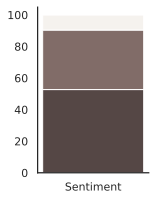

In [46]:
import matplotlib.pyplot as plt

# Define the labels and values
labels = ['Positive', 'Negative', 'Neutral']
sizes = df2['sentiment_label_roberta'].value_counts().to_list()
size_pct = [52.7, 37.7, 9.5]
# Define the custom colors
custom_colors = ["#554745", "#816c68", "#f5f2ee"]

plt.rcParams['figure.figsize'] = [2,3]

 
# create data
x = ['Sentiment']
y1 = [10, 20, 10, 30]

y1 = np.array([52.7])
y2 = np.array([37.7])
y3 = np.array([9.5])
 
# plot bars in stack manner
bars=[]
bars.append(plt.bar(x, y1, color=custom_colors[0]))
bars.append(plt.bar(x, y2, bottom=y1, color=custom_colors[1]))
bars.append(plt.bar(x, y3, bottom=y1+y2, color=custom_colors[2]))

# Remove the chart border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()


In [47]:
df2_sent = df2[df2['sentiment_label_roberta'] != 'LABEL_1']
df2_sent.shape

(127688, 18)

In [8]:
df2_pos = df2[df2['sentiment_label_roberta'] == 'LABEL_2']
df2_neg = df2[df2['sentiment_label_roberta'] == 'LABEL_0']

In [9]:
documents_pos = df2_pos['clean_text_sent'].tolist()
documents_neg = df2_neg['clean_text_sent'].tolist()

### Topic Modelling on Positive text

In [ ]:
%%time
from tqdm import tqdm

pos_topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
# Use tqdm to track progress
with tqdm(total=len(documents_pos), desc="Fitting BERTopic") as pbar:
    topics = pos_topic_model.fit_transform(documents_pos)
    pbar.update(len(documents_pos))

# Access the probabilities separately
pos_probs = pos_topic_model.transform(documents_pos)

In [15]:
# Save the model to a file
pos_topic_model.save("roberta_pos.pkl")

# Load the model from the saved file
loaded_model_pos = BERTopic.load("roberta_pos.pkl")

In [ ]:
topics, probs = pos_topic_model.topics_, pos_topic_model.probabilities_
df2_pos['bert_topic'] = topics

In [16]:
%%time

freq = loaded_model_pos.get_topic_info()

print(f"Topics found: {freq.shape[0]}")

Topics found: 139
CPU times: user 4.57 ms, sys: 150 µs, total: 4.72 ms
Wall time: 3.95 ms


In [ ]:
freq.head(20)